In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

In [2]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 


import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}

In [186]:
model = unet.get_unet(224, 224)

In [187]:
def load(path, random=True, standardize=True):
    if os.path.basename(os.path.dirname(path)) == 'raw':
        patches = glob(os.path.join(path, 'patch*.npy'))
        patch = np.load(patches[np.random.randint(len(patches))])
        if standardize:

            return np.dstack([
                scipy.ndimage.zoom(patch[..., 0], .7),
                scipy.ndimage.zoom(patch[..., -1], .7, order=0)
            ])
        
        return patch
    
    patch = np.load(os.path.join(path, 'patch.npy'))
    if random:
        return patch[np.random.randint(len(patch))]
    return patch[0]

In [188]:
def preprocess_test(patch):
    window = min(min(patch.shape), int(1.7 * SIDE))
    point = np.array(patch.shape) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape) - window)
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = np.zeros((SIDE, SIDE, 2))
    clip = cv2.resize(patch, dsize=(SIDE, SIDE))
    return clip

In [189]:
def preprocess_val(patch):
    window = min(min(patch.shape[:-1]), SIDE)
    point = np.array(patch.shape[:-1]) // 2
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

#     clip = np.zeros((SIDE, SIDE, 2))
#     clip[..., 0] = cv2.resize(patch[..., 0], dsize=(SIDE, SIDE))
#     clip[..., -1] = cv2.resize(patch[..., -1], dsize=(SIDE, SIDE)) 
#     return clip
    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])

In [190]:
def preprocess_train(patch):
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    
    if np.random.randint(3):
        shift = np.random.uniform(-.2, .2, size=2)
        shift *= np.array(patch.shape[:2])
        patch = np.dstack([
            scipy.ndimage.shift(patch[..., 0], shift),
            scipy.ndimage.shift(patch[..., -1], shift, order=0)
        ])
        
    if np.random.randint(3):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., :-1], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
    
    scale = np.random.uniform(.5, 1.5)
    window = min(min(patch.shape[:-1]), int(SIDE * scale))
    if np.count_nonzero(patch[..., 1]):
        coords = np.array(np.where(patch[..., 1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.random.randint(0, min(patch.shape[:-1]) - window + 1)
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]


#     clip = np.zeros((SIDE, SIDE, 2))
#     clip[..., 0] = cv2.resize(patch[..., 0], dsize=(SIDE, SIDE))
#     clip[..., -1] = cv2.resize(patch[..., -1], dsize=(SIDE, SIDE)) 

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])

In [191]:
SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [192]:
def test_generator(patient, train_mode=False, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_test, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed, -1) + 199.) / 461.

In [194]:
def generator(paths, train_mode=False, batch_size=BATCH_SIZE, shuffle_coef=.7):
    while True:
        paths = [
            os.path.join(
                os.path.dirname(os.path.dirname(path)), 
                os.path.basename(path)
            ) 
            if os.path.basename(os.path.dirname(path)) == 'raw'
            else path
            for path in paths
        ]
        if train_mode:
            np.random.shuffle(paths)
            paths = [
                os.path.join(os.path.dirname(path), 'raw', os.path.basename(path)) 
                if shuffle_coef * len(paths) >= i 
                else path 
                for i, path in enumerate(paths)
            ]
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
            with Pool(4) as pool:
                processed = pool.map(load, batch)

            if train_mode:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_train, processed)
            else:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_val, processed)
            processed = np.array(processed)
            yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0

In [147]:
patient_ids = glob(os.path.join(PATHS['DATA'], 'raw', '*', 'patch_0.npy'))
patient_ids = [os.path.dirname(pid) for pid in patient_ids]
patient_ids = [os.path.join(
                    os.path.dirname(os.path.dirname(pid)), 
                    os.path.basename(pid)
                ) for pid in patient_ids]
patient_ids = [pid for pid in patient_ids if len(os.path.basename(pid)) == 9]

train = patient_ids[:-int(SPLIT * len(patient_ids))]
test = patient_ids[-int(SPLIT * len(patient_ids)):]

In [16]:
from keras.callbacks import ModelCheckpoint

In [154]:
test_gen = generator(test, train_mode=False)
a = next(test_gen)

p = model.predict(a[0])
p1 = model.predict(np.flip(a[0], 1))
p2 = model.predict(np.flip(a[0], 2))
p3 = model.predict(np.flip(np.flip(a[0], 2), 1))

In [283]:
patient, meta = load_utils.load_patient(PATHS['DATA'], test[18], metadata=True)
print(patient.shape)

test_gen = test_generator(patient)
arr = np.concatenate([next(test_gen) for i in range(len(patient) // BATCH_SIZE + 1)])
test_gen = test_generator(patient)
p = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 1))
p1 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(patient, 2))
p2 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)
test_gen = test_generator(np.flip(np.flip(patient, 1), 2))
p3 = model.predict_generator(test_gen, len(patient) // BATCH_SIZE + 1)

(138, 512, 512)


In [284]:
pred = np.mean(
    np.stack([
        p, 
        np.flip(p1, 1), 
        np.flip(p2, 2), 
        np.flip(np.flip(p3, 1), 2)
    ], -1), 
    -1
)

In [276]:
patient[250]

array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       ..., 
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024],
       [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16)

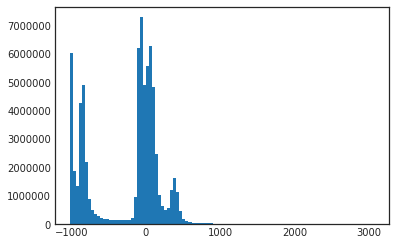

In [272]:
plt.hist(patient[patient != 0], 100);

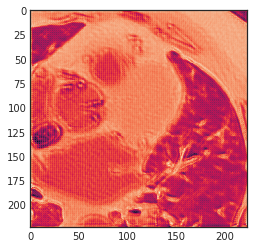

In [287]:
plt.imshow(pred[100, :400, :400, 0])

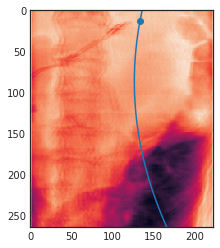

In [278]:
summedx = (pred[..., 0]).sum(1)
plt.imshow(summedx)

x, y = np.asarray(np.where(pred[..., 0] > .5))[[0, 2]]
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

point = np.random.choice(np.unique(x))
a = p(point + 1) - p(point)
a = np.tan(np.arctan(a) + np.pi / 2)
w = np.poly1d([a, p(point) - a * point])

xp = np.linspace(x.min(), x.max(), 100)
# xw = np.linspace(point - 50, point + 50, 100)
plt.plot(p(xp), xp, '-');
# plt.plot(w(xw), xw, '-');
plt.scatter(p(point), point)
# plt.axis('off');

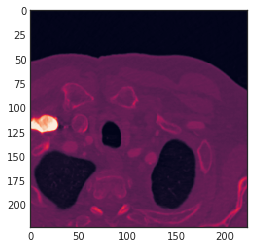

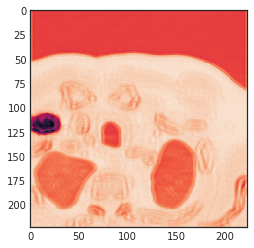

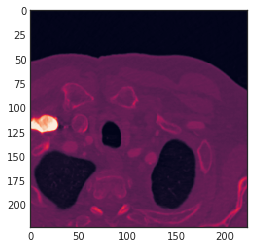

In [268]:
i = 100
plt.imshow(arr[i, ..., 0])
plt.show();
plt.imshow((pred[i, ..., 0] > .9) + pred[i, ..., 0]);
plt.show();
plt.imshow(arr[i, ..., 0] + (pred[i, ..., 0] > .9).astype(np.float));

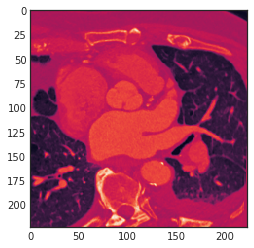

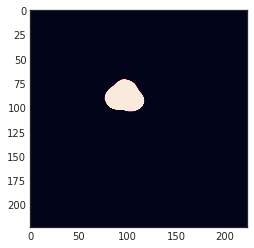

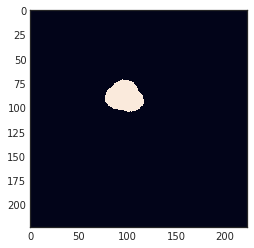

In [163]:
i = 7
plt.imshow(a[0][i, ..., 0])
plt.show()
plt.imshow(
    np.dstack([
        p[i, ..., 0], 
        np.flip(p1[i, ..., 0], 0), 
        np.flip(p2[i, ..., 0], 1), 
        np.flip(np.flip(p3[i, ..., 0], 1), 0),
    ]).mean(-1)
)
plt.show()
plt.imshow(a[1][i, ..., 0])
plt.show()

In [148]:
import warnings
warnings.filterwarnings('ignore')

In [151]:
cval = 0
NUM = 300
for i in range(NUM):
    train_gen = generator(train, train_mode=True)

    model.fit_generator(
        train_gen,
        steps_per_epoch= 10 * len(train) // BATCH_SIZE + 1, 
        verbose=1, 
    )

    test_gen = generator(test, train_mode=False)
    valeval = model.evaluate_generator(test_gen, 3)

    print('Iteration %s/%s \n val dice: %s'%(i, NUM, valeval[0]))
    if valeval[0] < cval:
        cval = valeval[0]
        model.save(os.path.join(PATHS['DATA'], 'unet_model'))
        print('-' * 50)

Epoch 1/1
203/203 [==============================] - 398s 2s/step - loss: -0.3550 - dice_coef: 0.3550
Iteration 0/300 
 val dice: -0.407663275798
--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 406s 2s/step - loss: -0.3452 - dice_coef: 0.3452
Iteration 1/300 
 val dice: -0.391397337119
Epoch 1/1
203/203 [==============================] - 408s 2s/step - loss: -0.3795 - dice_coef: 0.3795
Iteration 2/300 
 val dice: -0.465018282334
--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 405s 2s/step - loss: -0.3654 - dice_coef: 0.3654
Iteration 3/300 
 val dice: -0.386804183324
Epoch 1/1
203/203 [==============================] - 408s 2s/step - loss: -0.3927 - dice_coef: 0.3927
Iteration 4/300 
 val dice: -0.541900773843
--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 409s 2s/step - loss: -0.3809 - dice_coef: 0.3809
Iteration 5/300

--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 440s 2s/step - loss: -0.7218 - dice_coef: 0.7218
Iteration 50/300 
 val dice: -0.873134156068
Epoch 1/1
203/203 [==============================] - 438s 2s/step - loss: -0.7163 - dice_coef: 0.7163
Iteration 51/300 
 val dice: -0.863059182962
Epoch 1/1
203/203 [==============================] - 413s 2s/step - loss: -0.7555 - dice_coef: 0.7555
Iteration 52/300 
 val dice: -0.842912038167
Epoch 1/1
203/203 [==============================] - 419s 2s/step - loss: -0.7547 - dice_coef: 0.7547
Iteration 53/300 
 val dice: -0.87793246905
--------------------------------------------------
Epoch 1/1
169/203 [=======================>......] - ETA: 1:11 - loss: -0.7462 - dice_coef: 0.7462

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 435s 2s/step - loss: -0.7241 - dice_coef: 0.7241
Iteration 60/300 
 val dice: -0.889494657516
--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 426s 2s/step - loss: -0.7487 - dice_coef: 0.7487
Iteration 61/300 
 val dice: -0.850711941719
Epoch 1/1
203/203 [==============================] - 441s 2s/step - loss: -0.7489 - dice_coef: 0.7489
Iteration 62/300 
 val dice: -0.883153855801
Epoch 1/1
203/203 [==============================] - 420s 2s/step - loss: -0.7523 - dice_coef: 0.7523
Iteration 63/300 
 val dice: -0.846699893475
Epoch 1/1
203/203 [==============================] - 426s 2s/step - loss: -0.7625 - dice_coef: 0.7625
Iteration 64/300 
 val dice: -0.86419826746
Epoch 1/1
203/203 [==============================] - 441s 2s/step - loss: -0.7847 - dice_coef: 0.7847
Iteration 65/300 
 val dice: -0.881999452909
Epoch 1/1
203/203 [==============================] - 436s 2s/step - loss: -0.7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 422s 2s/step - loss: -0.7832 - dice_coef: 0.7832
Iteration 81/300 
 val dice: -0.899083872636
Epoch 1/1
203/203 [==============================] - 427s 2s/step - loss: -0.7451 - dice_coef: 0.7451
Iteration 82/300 
 val dice: -0.882851660252
Epoch 1/1
203/203 [==============================] - 434s 2s/step - loss: -0.7797 - dice_coef: 0.7797
Iteration 83/300 
 val dice: -0.890545964241
Epoch 1/1
203/203 [==============================] - 416s 2s/step - loss: -0.7748 - dice_coef: 0.7748
Iteration 84/300 
 val dice: -0.86503714323
Epoch 1/1
203/203 [==============================] - 419s 2s/step - loss: -0.7679 - dice_coef: 0.7679
Iteration 85/300 
 val dice: -0.853226900101
Epoch 1/1
203/203 [==============================] - 426s 2s/step - loss: -0.7657 - dice_coef: 0.7657
Iteration 86/300 
 val dice: -0.886172990004
Epoch 1/1
203/203 [==============================] - 413s 2s/step - loss: -0.7672 - dice_coef: 0.7672
Iteration 87/300 
 val dice

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 427s 2s/step - loss: -0.8029 - dice_coef: 0.8029
Iteration 102/300 
 val dice: -0.903251846631
Epoch 1/1
203/203 [==============================] - 442s 2s/step - loss: -0.7929 - dice_coef: 0.7929
Iteration 103/300 
 val dice: -0.888293683529
Epoch 1/1
203/203 [==============================] - 418s 2s/step - loss: -0.8030 - dice_coef: 0.8030
Iteration 104/300 
 val dice: -0.899452428023
Epoch 1/1
203/203 [==============================] - 451s 2s/step - loss: -0.7846 - dice_coef: 0.7846
Iteration 105/300 
 val dice: -0.90229678154
Epoch 1/1
203/203 [==============================] - 447s 2s/step - loss: -0.8189 - dice_coef: 0.8189
Iteration 106/300 
 val dice: -0.907841722171
Epoch 1/1
203/203 [==============================] - 430s 2s/step - loss: -0.8058 - dice_coef: 0.8058
Iteration 107/300 
 val dice: -0.914120256901
Epoch 1/1
203/203 [==============================] - 438s 2s/step - loss: -0.8315 - dice_coef: 0.8315
Iteration 108/300 
 v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 424s 2s/step - loss: -0.8292 - dice_coef: 0.8292
Iteration 123/300 
 val dice: -0.890647967656
Epoch 1/1
203/203 [==============================] - 431s 2s/step - loss: -0.7878 - dice_coef: 0.7878
Iteration 124/300 
 val dice: -0.904079417388
Epoch 1/1
203/203 [==============================] - 425s 2s/step - loss: -0.8005 - dice_coef: 0.8005
Iteration 125/300 
 val dice: -0.891723811626
Epoch 1/1
203/203 [==============================] - 439s 2s/step - loss: -0.8163 - dice_coef: 0.8163
Iteration 126/300 
 val dice: -0.90146034956
Epoch 1/1
203/203 [==============================] - 438s 2s/step - loss: -0.8221 - dice_coef: 0.8221
Iteration 127/300 
 val dice: -0.917754530907
Epoch 1/1
203/203 [==============================] - 410s 2s/step - loss: -0.8012 - dice_coef: 0.8012
Iteration 128/300 
 val dice: -0.905288139979
Epoch 1/1
203/203 [==============================] - 428s 2s/step - loss: -0.8385 - dice_coef: 0.8385
Iteration 129/300 
 v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 420s 2s/step - loss: -0.8390 - dice_coef: 0.8390
Iteration 144/300 
 val dice: -0.912696401278
Epoch 1/1
203/203 [==============================] - 431s 2s/step - loss: -0.8223 - dice_coef: 0.8223
Iteration 145/300 
 val dice: -0.931854089101
--------------------------------------------------
Epoch 1/1
203/203 [==============================] - 425s 2s/step - loss: -0.8249 - dice_coef: 0.8249
Iteration 146/300 
 val dice: -0.892013172309
Epoch 1/1
203/203 [==============================] - 431s 2s/step - loss: -0.7944 - dice_coef: 0.7944
Iteration 147/300 
 val dice: -0.913926124573
Epoch 1/1
203/203 [==============================] - 442s 2s/step - loss: -0.8195 - dice_coef: 0.8195
Iteration 148/300 
 val dice: -0.916511595249
Epoch 1/1
203/203 [==============================] - 435s 2s/step - loss: -0.8075 - dice_coef: 0.8075
Iteration 149/300 
 val dice: -0.909177978834
Epoch 1/1
203/203 [==============================] - 447s 2s/step - los

203/203 [==============================] - 440s 2s/step - loss: -0.8107 - dice_coef: 0.8107
Iteration 199/300 
 val dice: -0.907393157482
Epoch 1/1
203/203 [==============================] - 455s 2s/step - loss: -0.8375 - dice_coef: 0.8375
Iteration 200/300 
 val dice: -0.913569708665
Epoch 1/1
203/203 [==============================] - 438s 2s/step - loss: -0.8526 - dice_coef: 0.8526
Iteration 201/300 
 val dice: -0.924097597599
Epoch 1/1
203/203 [==============================] - 444s 2s/step - loss: -0.8529 - dice_coef: 0.8529
Iteration 202/300 
 val dice: -0.914963344733
Epoch 1/1
203/203 [==============================] - 433s 2s/step - loss: -0.8501 - dice_coef: 0.8501
Iteration 203/300 
 val dice: -0.902720749378
Epoch 1/1
203/203 [==============================] - 434s 2s/step - loss: -0.8337 - dice_coef: 0.8337
Iteration 204/300 
 val dice: -0.922318677107
Epoch 1/1
203/203 [==============================] - 426s 2s/step - loss: -0.8241 - dice_coef: 0.8241
Iteration 205/300 
 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



203/203 [==============================] - 433s 2s/step - loss: -0.8510 - dice_coef: 0.8510
Iteration 287/300 
 val dice: -0.919837037722
Epoch 1/1
203/203 [==============================] - 442s 2s/step - loss: -0.8242 - dice_coef: 0.8242
Iteration 288/300 
 val dice: -0.898428936799
Epoch 1/1
203/203 [==============================] - 439s 2s/step - loss: -0.8436 - dice_coef: 0.8436
Iteration 289/300 
 val dice: -0.923008541266
Epoch 1/1
203/203 [==============================] - 422s 2s/step - loss: -0.8601 - dice_coef: 0.8601
Iteration 290/300 
 val dice: -0.927332500617
Epoch 1/1
203/203 [==============================] - 437s 2s/step - loss: -0.8590 - dice_coef: 0.8590
Iteration 291/300 
 val dice: -0.915133595467
Epoch 1/1
203/203 [==============================] - 445s 2s/step - loss: -0.8480 - dice_coef: 0.8480
Iteration 292/300 
 val dice: -0.914167801539
Epoch 1/1
203/203 [==============================] - 442s 2s/step - loss: -0.8533 - dice_coef: 0.8533
Iteration 293/300 
 

In [424]:
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [185]:
model.save(os.path.join(PATHS['DATA'], '__unet_model__'))

In [321]:
cval = -0.914
NUM = 100
for i in range(NUM):
    train_gen = generator(train, train_mode=True, batch_size=int(2 * BATCH_SIZE))

    model.fit_generator(
        train_gen,
        steps_per_epoch= 10 * len(train) // int(2 * BATCH_SIZE) + 1, 
        verbose=1, 
    )

    test_gen = generator(test, train_mode=False)
    valeval = model.evaluate_generator(test_gen, 3)

    print('Iteration %s/%s \n val dice: %s'%(i, NUM, valeval[0]))
    if valeval[0] < cval:
        cval = valeval[0]
        model.save(os.path.join(PATHS['DATA'], 'unet_model'))
        print('-' * 50)

Epoch 1/1
66/66 [==============================] - 179s 3s/step - loss: -0.8924 - dice_coef: 0.8924
Iteration 0/100 
 val dice: -0.887414555292
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8906 - dice_coef: 0.8906
Iteration 1/100 
 val dice: -0.89599953471
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8914 - dice_coef: 0.8914
Iteration 2/100 
 val dice: -0.885314422685
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8957 - dice_coef: 0.8957
Iteration 3/100 
 val dice: -0.881032044823
Epoch 1/1
66/66 [==============================] - 164s 2s/step - loss: -0.8969 - dice_coef: 0.8969
Iteration 4/100 
 val dice: -0.897783566166
Epoch 1/1
66/66 [==============================] - 165s 2s/step - loss: -0.8932 - dice_coef: 0.8932
Iteration 5/100 
 val dice: -0.893910225984
Epoch 1/1
66/66 [==============================] - 165s 2s/step - loss: -0.8950 - dice_coef: 0.8950
Iteration 6/100 
 val dice: -0.894827

In [293]:
test_gen = generator(test, train_mode=False)
model.evaluate_generator(test_gen, 3)

[-0.69859261448318899, 0.69859261448318899]

In [298]:
test_gen = generator(test, train_mode=False)
model.evaluate_generator(test_gen, 3)

[-0.68482592460271474, 0.68482592460271474]